In [1]:
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage import gaussian_filter
import numpy as np
from skimage.transform import resize, rotate
from PIL import Image
import nibabel as nib

In [3]:
%matplotlib inline

In [4]:
test_img_path = "image_files/test_image/presentation_mri.jpg"

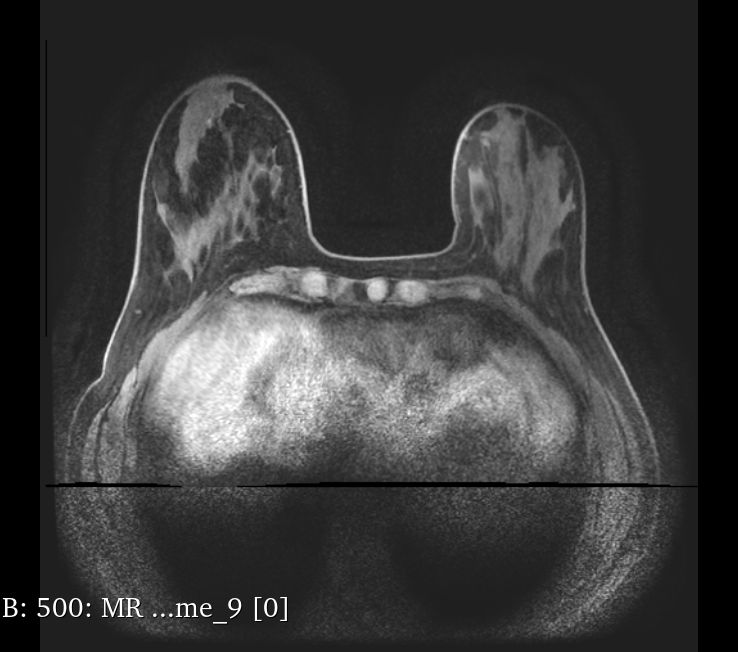

In [5]:
from PIL import Image
test_img = Image.open(test_img_path)
test_img.show()

# Rotation & blur

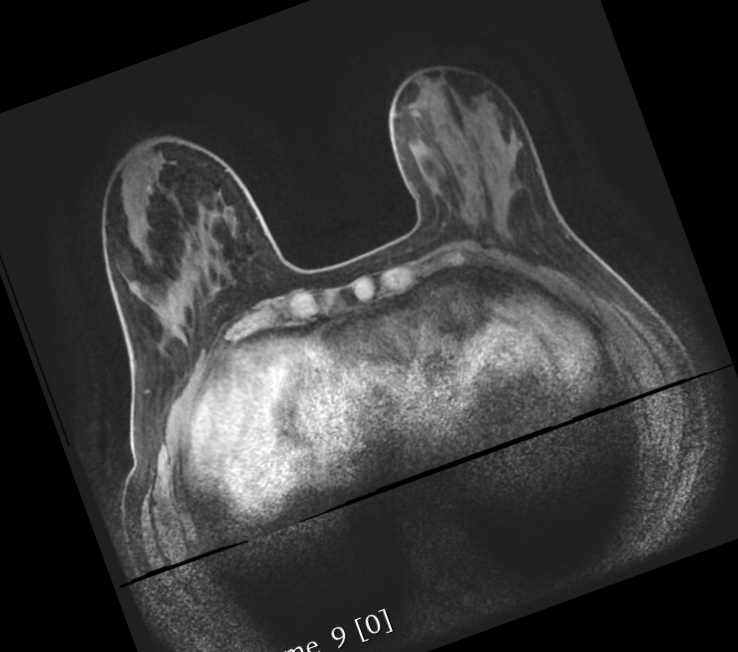

In [6]:
import skimage
import numpy as np

rotated_array = skimage.transform.rotate(np.array(test_img),20, preserve_range=True)
rotated_img = Image.fromarray(np.uint8(rotated_array))
rotated_img.show()

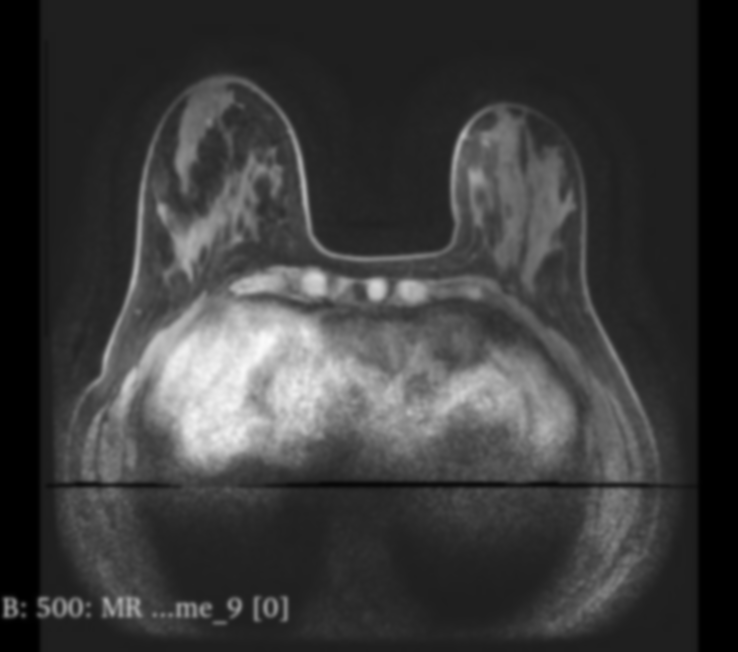

In [7]:
blurred_array = skimage.filters.gaussian(np.array(test_img),sigma=2,preserve_range=True)
blurred_img = Image.fromarray(np.uint8(blurred_array))
blurred_img.show()

# Generating augmented frames

In [8]:
def imgage_path_to_array(image_path):
    if '.dcm' in image_path:
        dicom_data = pydicom.dcmread(image_path)
        return dicom_data.pixel_array
    elif '.nii.gz' in image_path:
        nifti_data = nib.load(image_path)
        return nifti_data.get_fdata()
    else:
        return np.array(Image.open(image_path))
    

In [9]:
def save_frame(frame, frame_number, save_frame_path, frame_name):
    frame_path = save_frame_path + f"{frame_name}_{frame_number:02d}.png"
    Image.fromarray((frame * 255).astype(np.uint8)).save(frame_path)
    img = plt.imread(frame_path)
    return img

In [10]:
def calculate_max_size(image_array, max_elongation):
    max_height = int(image_array.shape[0] * (1 + max_elongation))
    max_width = int(image_array.shape[1] * (1 + 0.25 * max_elongation))
    return max_height, max_width

In [11]:
def generate_random_factors(num_frames, random):
    if random:
        rnd_factors = {
            "rnd_me": np.random.rand() - 0.5,
            "rnd_ts": np.random.randint(0, int(num_frames * 0.15)) - int(num_frames * 0.15 * 0.5),
            "rnd_blur_size": (np.random.rand() - 0.5) * 2,
            "rnd_blur_shift": (np.random.rand() - 0.5) * np.pi
        }
    else:
        rnd_factors = {"rnd_me": 0, "rnd_ts": 0, "rnd_blur_size": 0, "rnd_blur_shift": 0}
    return rnd_factors

def apply_random_factors(max_elongation, blur_size, rnd_factors):
    max_elongation += rnd_factors["rnd_me"] * 0.015
    blur_size += rnd_factors["rnd_blur_size"]
    blur_shift = rnd_factors["rnd_blur_shift"]
    return max_elongation, blur_size, blur_shift

In [12]:
def generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size):
    t = np.linspace(0, 2 * np.pi, num_frames)[frame_number]
    elongation_factor_height = 1.0 + max_elongation * np.sin(t)
    elongation_factor_width = 1.0 + max_elongation * np.sin(t) * 0.25
    output_image = resize(image_array, (int(image_array.shape[0] * elongation_factor_height),
                                        int(image_array.shape[1] * elongation_factor_width)),
                          anti_aliasing=True, mode='reflect')
    
    sigma = 0 + (blur_size * np.abs(np.sin(t + blur_shift)))
    output_image = gaussian_filter(output_image, sigma=(sigma, 0, 0))

    background = np.zeros((max_size[0], max_size[1], 3))
    top_offset = max_size[0] - output_image.shape[0]
    left_offset = int((max_size[1] - output_image.shape[1]) / 2)
    background[top_offset:top_offset + output_image.shape[0], left_offset:left_offset + output_image.shape[1]] = output_image[..., :3]
    return background

In [13]:
# Adjusted function to save each frame and return them for animation display
def generate_effect_frames_for_animation(image_path, save_frame_path,frame_name = "frame", num_frames=10, max_elongation=0.025, blur=True, random=False):
    
    # get array from img path
    image_array = imgage_path_to_array(image_path)

    blur_size = 3
    blur_shift = 0

    
    #generate random factor for amplitude, time scale, blur 
    rnd_factors = generate_random_factors(num_frames, random)
    max_elongation, blur_size, blur_shift = apply_random_factors(max_elongation, blur_size, rnd_factors)
    
    
    # Calculate the maximum elongation size of the output image (biggest elongations)
    max_height, max_width = calculate_max_size(image_array, max_elongation)
    max_size = (max_height, max_width)

    frames = []
    for frame_number in range(num_frames):
        background = generate_frame(image_array, frame_number, num_frames, max_elongation, blur_size, blur_shift, max_size)
        img = save_frame(background, frame_number, save_frame_path, frame_name)
        frames.append([img])

    return frames


# Save frames, and display as animation

In [14]:
def frames_to_animation():
    pass

In [15]:
num_frames = 10
test_img_path = "image_files/test_image/presentation_mri.jpg"
save_frame_path = "image_files/test_image/frames/" #needs '/' at the end; TODO: add fix in function
# test_img_path = "image_files/test_patient/p_001.nii.gz" TODO: add .nii.gz compatibility
# save_frame_path = "image_files/test_patient/frames/" #needs '/' at the end TODO: add fix in function

frame_name = "frame"

# Generate frames with effects for animation
generate_effect_frames_for_animation(test_img_path,save_frame_path,frame_name,num_frames=num_frames)


# Set up the figure
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axis('off')  # Turn off axes

# Load all the saved frames
frames = []  # To hold the images for animation
for i in range(0, num_frames):
    frame_path = save_frame_path+f"{frame_name}_{i:02d}.png"
    frame = Image.open(frame_path)
    frames.append([plt.imshow(frame, animated=True)])

# Create the animation
ani = animation.ArtistAnimation(fig, frames, interval=(2000/num_frames), blit=True, repeat_delay=1000)
ani.save('animation.gif', writer='pillow')
# Show the animation
plt.close()  # Close the static figure to prevent it from displaying
# ani  # This will show the animation in the output cell
%matplotlib inline
HTML(ani.to_jshtml())